# Simulación 1DOF de Dinámica del Cohete (Algoritmo MIT)
Santiago Arroyo Lozano

In [15]:
"""
@author Santiago Arroyo
@date 6/11/2021

Simulacion de cohete unidimensional
"""
import numpy as np
from math import pi, ceil
from collections import defaultdict

default_factory = (lambda: None)
      
# Definimos los diccionarios que nos ayudaran a graficar
grafica_peso = defaultdict(default_factory)
grafica_fuerza = defaultdict(default_factory)
grafica_altura = defaultdict(default_factory)
grafica_inercia = defaultdict(default_factory)
grafica_impulso = defaultdict(default_factory)
grafica_arrastre = defaultdict(default_factory)
grafica_velocidad = defaultdict(default_factory)
grafica_aceleracion = defaultdict(default_factory)

#[--------------------> DATOS INICIALES <--------------------]
g = 9.807             # [m/s^2] Gravedad
D = 0.0                 # [N] Arrastre
m = 1.0                 # [kg] Masa seca
F = 0.0                 # [N] Fuerza
T = 150              # [N] Thrust(Impulso)
p = 1.2               # [kg/m^3] Densidad del aire en CDMX
h = 0.0                 # [m] Altura (inica con valor 0)
V = 0.0                 # [m/s] velocidad (inica con valor 0)
m_fuel = 0.1         # [g/s] Flujo de masa (Combustible)
r = 0.2             # [m] Radio del fuselaje
A = pi*r**2           # [m] Area de superficie

#[--------------------> ARBITRARIOS <--------------------]
Cd_Min = 0.4          # Valor arbitrario para calcular coeficiente de arrastre 
l_launchpad = 3;       # Longitud del riel de la base de lanzamiento
C_D = 0.5             # Coeficiente de arrastre constante
delta_t = 0.02        # Tasa de cambio del tiempo
    
#Parametros para calcular el cofiente de arrastre Supersonico
p1 = 0.6387;p2 =-2.569;p3 = 4.717;p4 =-1.924;p5 =-3.301;p6 = 2.513
q1 =-4.526;q2 = 8.368;q3 =-5.147;q4 =-1.908;q5 = 2.27
#p's y q's calculadas con matlab curve fitting

N = ceil(15/delta_t)
# Iniciamos con las iteraciones
for t in np.arange(0,round(10+delta_t,2),delta_t):
    t = round(t,2) #Debemos redondear por problemas de Python con los números flotantes
    if t >= round(2+delta_t,2):
        T = m_fuel = 0
    if V >= 0:
        F = -m*g-D+T
    else:
        F = -m*g+D-T
    print(V)
    Mach = round(V/343,2)  #Numero de Mach
#   C_D = round(Cd_Min*(p1*Mach**5 + p2*Mach**4 + p3*Mach**3 + p4*Mach**2 + p5*Mach + p6) / \
#              (Mach**5 + q1*Mach**4 + q2*Mach**3 + q3*Mach**2 + q4*Mach + q5),2)   # coeficiente de arrastre
    if Mach > 1:
        C_D = 0.6
    a = round(F/m,3)
    h = h + V*(t-round(t-delta_t,2))
    m = m - round(m_fuel*delta_t, 3)
    I = 1/2*m*r**2 #Fórmula de momento de incercia de un cuerpo cilíndrico
    V = V + a*t
    W = m*g # Fórmula de peso en relacióna masa y gravedad
    D = (1/2)*p*(V**2)*C_D*A
    
    # Guardamos los valores en sus respectivos diccionarios
    grafica_peso[t] = W
    grafica_fuerza[t] = F
    grafica_altura[t] = h
    grafica_inercia[t] = I
    grafica_impulso[t] = T
    grafica_arrastre[t] = D
    grafica_velocidad[t] = V
    grafica_aceleracion[t] = a
    
    # Cuando la altura sea cero quiere decir que estamos en Tierra nuevamente, termina la simulación. 
    # En caso contrario seguimos
    if t >= 15:
        break
        
#Esta llamada es redundante porque podriamos sacar la altura más arriba pero como es lineal no importa tanto
max_h = max(grafica_altura.values())
print("La altura máxima es", max_h,"[m]")

0.0
0.0
2.80988
8.429760000000002
16.73394
27.19482
38.54942
48.786739999999995
55.971399999999996
59.58868
60.78136
61.00876
61.029
61.033080000000005
61.037760000000006
61.04224000000001
61.04674000000001
61.05122000000001
61.05564000000001
61.05996000000001
61.06452000000001
61.06852000000001
61.07356000000001
61.07708000000001
61.082600000000006
61.08500000000001
61.092000000000006
61.09252000000001
61.10278000000001
61.09718000000001
61.119220000000006
61.08982
61.16174
61.0235
61.34426
60.60986
62.40886
57.80518
69.75174
34.81226
115.40966
-198.63514
987.99834
-32629.07802
45285585.522760004
-89519975284842.69
3.58553023582588e+26
-5.8927921354640405e+51
1.6298748730695964e+102
-1.2762145638593739e+203
inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

C:\Users\santi\AppData\Local\Temp\ipykernel_19428\1167447395.py:69: RuntimeWarning: overflow encountered in double_scalars
  D = (1/2)*p*(V**2)*C_D*A
C:\Users\santi\AppData\Local\Temp\ipykernel_19428\1167447395.py:67: RuntimeWarning: invalid value encountered in double_scalars
  V = V + a*t


# Graficamos los resultados:

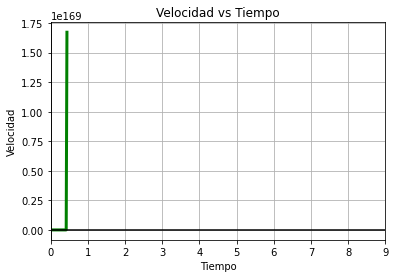

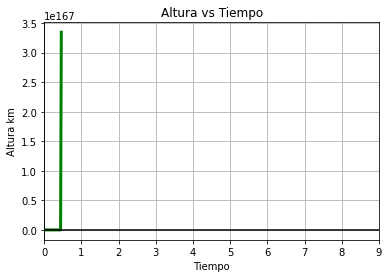

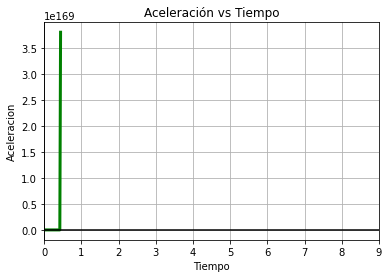

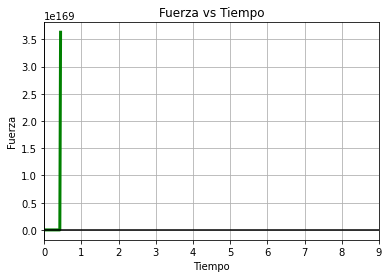

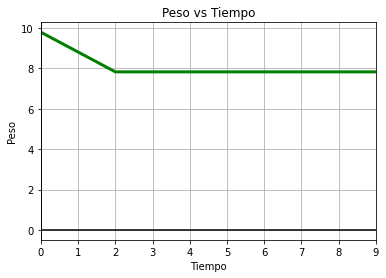

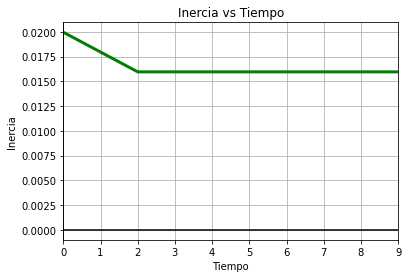

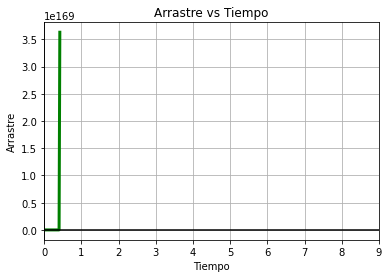

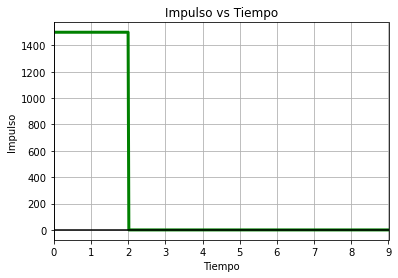

In [7]:
import matplotlib.pyplot as plt

# Grafica de velocidad
plt.plot(grafica_velocidad.keys(), grafica_velocidad.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(-500,500) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.xlabel('Tiempo')
plt.ylabel('Velocidad')
plt.title('Velocidad vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de altura
plt.plot(grafica_altura.keys(), grafica_altura.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(0,800) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.xlabel('Tiempo')
plt.ylabel('Altura km')
plt.title('Altura vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de aceleracion
plt.plot(grafica_aceleracion.keys(), grafica_aceleracion.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(-120,200) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.xlabel('Tiempo')
plt.ylabel('Aceleracion')
plt.title('Aceleración vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de fuerza
plt.plot(grafica_fuerza.keys(), grafica_fuerza.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(-160,200) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.xlabel('Tiempo')
plt.ylabel('Fuerza')
plt.title('Fuerza vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de peso
plt.plot(grafica_peso.keys(), grafica_peso.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(8,12) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.xlabel('Tiempo')
plt.ylabel('Peso')
plt.title('Peso vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de inercia
plt.plot(grafica_inercia.keys(), grafica_inercia.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(0,0.001) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.grid(True, which='both')
plt.xlabel('Tiempo')
plt.ylabel('Inercia')
plt.title('Inercia vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de arrastre
#plt.plot(grafica_arrastre.keys(), grafica_arrastre.values(), color='green', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6)
plt.plot(grafica_arrastre.keys(), grafica_arrastre.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(0,150) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.grid(True, which='both')
plt.xlabel('Tiempo')
plt.ylabel('Arrastre')
plt.title('Arrastre vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Grafica de impulso
plt.plot(grafica_impulso.keys(), grafica_impulso.values(), color='green', linewidth = 3, markerfacecolor='blue', markersize=6)
#plt.ylim(0,160) # limites eje y
plt.xlim(0,9)  # limites eje x
plt.grid(True, which='both')
plt.xlabel('Tiempo')
plt.ylabel('Impulso')
plt.title('Impulso vs Tiempo')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

El valor final de $t$ es el tiempo total de la simulación

In [18]:
t

10.0

**Ejericio Avionica**<br>
Adjunta un programa funcional (en el lenguaje que sea) que reciba un dato numérico a la vez, imprima los tres últimos datos (incluyendo el que se acaba de ingresar) y el promedio de estos tres. Repetir indefinidamente, que pida otro dato y se deseche el más antiguo y vuela a imprimir los datos y el promedio. Es obligatorio ocupar un arreglo, y máximo dos variables escalares. (No se pueden usar colas u otra estructura de datos) *
1 punto


In [ ]:
"""
@author Santiago Arroyo
@date 05/09/2021
Debido a que como tal los arreglos de Python son en realidad listas doblemente ligadas, 
    usaremos una libreria que nos ayudará a ser más eficientes con la memoria y darle vida a un arreglo de verdad    
"""
from array import *
i = resultado = 0
arreglo = array('i', [1,2,3,4,5]) #‘i’ -> Respresenta entero de tamaño de 2 bytes
while True:
    try:
        arreglo[i] = int(input("Por favor introduce un número: "))
        i += 1
        if i >= 3:
            i = 0
            resultado = (arreglo[0]+arreglo[1]+arreglo[2])/3
            print("El primer dato fue", arreglo[0])
            print("El primer dato fue", arreglo[1])
            print("El primer dato fue", arreglo[2])
            print("El resultado es: ", resultado)   
    except ValueError:
        print("Oops!  Por favor inserta un número válido.")